# Question n°1

In [122]:
#We generate from an alpha distribution with jax
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import qmc
from scipy.special import logsumexp 
from functools import partial
from jax import random
from tqdm import tqdm
from scipy.stats import multivariate_normal
import pandas as pd
import seaborn as sns

In [ ]:


def simulation_alpha_stable_mc(alpha: float, beta: float, gamma: float, delta: float, n: int, key):
    """
    Generate n samples from an alpha-stable distribution with parameters alpha, beta, gamma, delta 
    using the Chambers–Mallows–Stuck method.

    Parameters:
        alpha (float): Stability parameter (0 < alpha <= 2).
        beta (float): Skewness parameter (-1 <= beta <= 1).
        gamma (float): Scale parameter.
        delta (float): Location parameter.
        n (int): Number of samples to generate.
        key (jax.random.PRNGKey): JAX random key.
        
    Returns:
        jnp.ndarray: A vector of n samples from the specified alpha-stable distribution.

    example:
        key = jax.random.PRNGKey(0)
        alpha = 1.5
        beta = 0.5
        gamma = 1.0
        delta = 0.0
        n = 10000
        samples = simulation_alpha_stable(alpha, beta, gamma, delta, n, key)

    """
    # Split the key to get independent streams for generating different random variables.
    key_u, key_w = jax.random.split(key)

    half_pi = jnp.pi / 2

    # Generate the required random variables.
    w = jax.random.exponential(key_w, shape=(n,))
    u = jax.random.uniform(key_u, minval=-half_pi, maxval=half_pi, shape=(n,))

    epsi = 1e-6  # Tolerance for comparing alpha with 1

    def branch_alpha_eq_1():
        # Formula for alpha == 1
        return (2 / jnp.pi) * (
            (half_pi + beta * u) * jnp.tan(u) -
            beta * jnp.log((half_pi * w * jnp.cos(u)) / (half_pi + beta * u))
        )

    def branch_alpha_neq_1():
        # Parameters used for the Chambers–Mallows–Stuck formula (alpha != 1)
        S = (1 + beta**2 * jnp.tan(half_pi * alpha)**2) ** (1 / (2 * alpha))
        B = (1 / alpha) * jnp.arctan(beta * jnp.tan(half_pi * alpha))
        return S * (jnp.sin(alpha * (u + B)) / (jnp.cos(u)) ** (1 / alpha)) * (
            (jnp.cos(u - alpha * (u + B)))/w
        ) ** ((1 - alpha) / alpha)

    # Choose the appropriate branch based on alpha.
    y = jax.lax.cond(jnp.abs(alpha - 1) < epsi, branch_alpha_eq_1, branch_alpha_neq_1)

    return gamma * y + delta


In [ ]:
y = simulation_alpha_stable_mc(1, 0, 0.5, 0, 1000, jax.random.PRNGKey(2))
# Plotting the histogram
plt.figure(figsize=(16, 6))
sns.histplot(y, bins=100, kde=True)
plt.title('Histogram of Alpha-Stable Distribution (alpha=1.5)')
plt.xlabel('Value')
plt.xlim(-100,100)
plt.ylabel('Frequency')

plt.ylim(0, 1000)
plt.grid()
plt.show()

# Question n°2

To generate n samples from an  alpha-stable, it is needed to sample from an Exp(1) and a Uniform(-pi/2 , pi/2), so this is where using RQMC is usefull. Indeed, instead of sampling from this laws, it is possible to use a Sobol sequence with scrambling.

Once this is done, there are two variables u,v \in [0,1]^2.

To get the u that is required, the following transformation is used : u' = u*pi - pi/2 //
To get the w that is required, the following transformation is used : w = -log(v)  (inverse CDF)

Then with the correct u and w, it is possible to generate the alpha-stable sample following the method from before.

In [ ]:
def simulation_alpha_stable_rqmc(alpha: float, beta: float, gamma: float, delta: float, n: int, seed : int = None):
    """
    Generate n samples from an alpha-stable distribution using an RQMC sequence.
    
    Parameters:
        alpha (float): Stability parameter (0 < alpha <= 2).
        beta (float): Skewness parameter (-1 <= beta <= 1).
        gamma (float): Scale parameter.
        delta (float): Location parameter.
        n (int): Number of samples to generate.
    
    Returns:
        jnp.ndarray: A vector of n samples from the specified alpha-stable distribution.
    """
    # 1. Generate a 2D Sobol sequence with scrambling (RQMC)
    sampler = qmc.Sobol(d=2, scramble=True)
    # Generate n points in [0,1]^2
    points = sampler.random(n)
    
    # 2. Transform the first coordinate to [-pi/2, pi/2] for u
    half_pi = jnp.pi / 2
    # Note: Convert the numpy array to a jax array if necessary
    u = jnp.array(points[:, 0]) * jnp.pi - half_pi
    
    # 3. Transform the second coordinate via the inverse CDF to get exponential variables
    v = jnp.array(points[:, 1])
    # Avoid issues with logarithm of zero by adding a small epsilon if needed.
    epsilon = 1e-10
    w = -jnp.log(v + epsilon)
    
    # 4. Calculate y using the Chambers–Mallows–Stuck method
    tol = 1e-6  # tolerance for checking if alpha ~ 1
    
    def branch_alpha_eq_1():
        return (2 / jnp.pi) * (
            (half_pi + beta * u) * jnp.tan(u) -
            beta * jnp.log((half_pi * w * jnp.cos(u)) / (half_pi + beta * u))
        )

    def branch_alpha_neq_1():
        S = (1 + beta**2 * jnp.tan(half_pi * alpha)**2) ** (1 / (2 * alpha))
        B = (1 / alpha) * jnp.arctan(beta * jnp.tan(half_pi * alpha))
        return S * (jnp.sin(alpha * (u + B)) / (jnp.cos(u)) ** (1/alpha)) * (
            (jnp.cos(u - alpha * (u + B))) / w
        ) ** ((1 - alpha) / alpha)
    
    y = jax.lax.cond(jnp.abs(alpha - 1) < tol, branch_alpha_eq_1, branch_alpha_neq_1)
    
    # 5. Apply the scale and location transformation.
    return gamma * y + delta


In [ ]:
def g(y):
    """
    Bounded function for which to compute the expectation.
    Here, we use g(y) = cos(y).
    """
    return jnp.cos(y)


def estimate_expectation_mc(alpha, beta, gamma, delta, n, reps):
    """ 
    Compute expectation estimates under the alpha-stable distribution using standard MC.
    """
    estimates = []
    for i in range(reps):
        # Use a different seed for each replication.
        key = jax.random.PRNGKey(i)
        samples = simulation_alpha_stable_mc(alpha, beta, gamma, delta, n, key)
        estimates.append(jnp.mean(g(samples)))
    return jnp.array(estimates)


def estimate_expectation_rqmc(alpha, beta, gamma, delta, n, reps, base_seed=123):
    """ 
    Compute expectation estimates under the alpha-stable distribution using RQMC.
    For each replication, reinitialize the scrambled Sobol generator with a different seed.
    """
    estimates = []
    for i in range(reps):
        seed = base_seed + i  # vary the seed for different scrambling
        samples = simulation_alpha_stable_rqmc(alpha, beta, gamma, delta, n, seed)
        estimates.append(jnp.mean(g(samples)))
    return jnp.array(estimates)

#------------------------------------------------------------------------------
# Comparison of MC vs. RQMC estimates
#------------------------------------------------------------------------------

# Parameters for the alpha-stable distribution
alpha = 1.7
beta = 0.5
gamma = 1.0
delta = 0.0
n_samples = 4096  # number of samples per replication (power of 2 for Sobol)
n_replications = 500  # number of replications

# Compute expectation estimates via MC and RQMC
mc_estimates = estimate_expectation_mc(alpha, beta, gamma, delta, n_samples, n_replications) 
rqmc_estimates = estimate_expectation_rqmc(alpha, beta, gamma, delta, n_samples, n_replications)

# Calculate statistics (mean and standard deviation over replications)
mc_mean = float(jnp.mean(mc_estimates))
mc_std  = float(jnp.std(mc_estimates))
rqmc_mean = float(jnp.mean(rqmc_estimates))
rqmc_std  = float(jnp.std(rqmc_estimates))

print("Standard Monte Carlo estimates of E[cos(Y)]:")
print(f"Mean: {mc_mean:.6f}, Std. Dev.: {mc_std:.6f}")
print("\nRQMC estimates of E[cos(Y)]:")
print(f"Mean: {rqmc_mean:.6f}, Std. Dev.: {rqmc_std:.6f}")

# Plotting the distribution of estimates for a visual comparison

plt.figure(figsize=(16,10))
plt.hist(mc_estimates, bins=15, alpha=0.6, label='MC estimates', color='C0')
plt.hist(rqmc_estimates, bins=15, alpha=0.6, label='RQMC estimates', color='C1')
plt.xlabel("Estimate of E[cos(Y)]")
plt.ylabel("Frequency")
plt.title("Comparison of MC vs. RQMC Expectation Estimates")
plt.legend()
plt.show() 

As expected, the variance is way smaller when RQMC is used.

Question n°3

The summary stastistics S1,S2,S3,S4,S5 are first defined.


In [ ]:
def mcculloch_estimator(x):
    x.sort()
    n = len(x)


def mcculloch_summary(x):
    """
    Calcule l’estimateur de McCulloch (ou un vecteur de 4 nombres)
    qui correspondent aux estimations de (alpha, beta, gamma, delta) à partir de x.
    """
    # Chercher l'estimateur de McCulloch pour alpha, beta, gamma, delta
    # (voir le papier de McCulloch, 1986)
    alpha_hat, beta_hat, gamma_hat, delta_hat = mcculloch_estimator(x)
    return np.array([alpha_hat, beta_hat, gamma_hat, delta_hat])

In [ ]:
def summary_stat_2(X, ksi =  0.25):
    """
    Calcule la statistique résumée pour x
    Grâce à la transformation de Zolotarev.
    """
    # 1) On tranfrome X en Z
    Z = np.array([X[3*i-2] - ksi * X[3*i-1] - (1-ksi) * X[3*i] for i in range(1, len(X)//3 + 1)]) 

    # 2) On calcule la statistique résumée grâec à la transformation de Zolotarev

    V = np.log(np.abs(Z)
               ) 
    U = np.sign(X)

    S_V = np.var(V
                 )
    S_U = np.var(U)

    eta_hat = np.mean(U)

    teta_hat = np.mean(V)
    
    v_tilde = 6/(np.pi)**2 * S_V - 1.5 * S_U + 1

    v_hat = max(v_tilde, (1+eta_hat)**2 * 0.25)
    delta_hat = np.mean(X)

    return np.array([v_hat , eta_hat, teta_hat, float(delta_hat)])





In [ ]:
def empirical_cf(X, t):

    """Retourne la fonction caractéristique empirique de X pour t"""

    return np.mean(np.exp(1j * t * X))

def u_hat(X, t) :
    """ Retourne la valeur de u_hat pour t, nécessaire pour la méthode des Press's of moments"""
    
    sum_cos = np.sum(np.cos(t * X))
    sum_sin = np.sum(np.sin(t * X))
    return np.arctan(sum_sin /sum_cos)  #Il y a une erreur dans le papier


def summary_stat_3(X,t1 = 0.2, t2=0.8, t3=0.1,t4=0.4) :
    #On calcule la valeurs estimateurs
    # 1) On calcule la fonction caractéristique empirique de X pour t1, t2, t3 et t4
    phi_t1 = empirical_cf(X, t1)
    phi_t2 = empirical_cf(X, t2)
    phi_t3 = empirical_cf(X, t3)
    phi_t4 = empirical_cf(X, t4)


    # 2) On calcule la statistique résumée
    log_gam_hat = (np.log(abs(t1))*np.log(-np.log(abs(phi_t2))) - np.log(abs(t2))*np.log(-np.log(abs(phi_t1))) ) / np.log(abs(t1)/abs(t2))
    alpha_hat = np.log((np.log(abs(phi_t1)))/np.log(abs(phi_t2))) / np.log(abs(t1)/abs(t2))

    beta_hat = (u_hat(X, t4)/t4 - u_hat(X, t3)/t3)/((abs(t4)**(alpha_hat-1) - abs(t3)**(alpha_hat-1))*(np.exp(log_gam_hat)**alpha_hat)*np.tan(alpha_hat*np.pi/2))
    delta_hat = (
         abs(t4)**(alpha_hat - 1) * u_hat(X, t3) / t3 - abs(t3)**(alpha_hat - 1) * u_hat(X, t4) / t4
        ) / (abs(t4)**(alpha_hat - 1) - abs(t3)**(alpha_hat - 1))
    # 3) On renvoie la statistique résumée
    return np.array([alpha_hat, beta_hat, np.exp(log_gam_hat), delta_hat])

In [ ]:
def s4(x):
    """
    Returns concatenated real and imaginary parts.
    """
    #positive grid
    t_pos = np.arange(0.5, 5.1, 0.5)
    #make ±
    t_vals = np.concatenate([t_pos, -t_pos])
    #important to standartise! 
    new_x=(x-np.mean(x))/(np.quantile(x,0.75)-np.quantile(x,0.25))
    #compute φ̂(t) for each t in our grid
    phi = np.array([np.mean(np.exp(1j * t * new_x)) for t in t_vals])
    return np.hstack((phi.real, phi.imag))

In [ ]:
def kolmogorov_smirnov_stat(X,Y):
    """
    Calcule la statistique de Kolmogorov-Smirnov entre deux échantillons X et Y.
    """
    n = len(X)
    m = len(Y)
    
    # On combine les deux échantillons et on les trie
    combined = np.concatenate((X, Y))
    sorted_combined = np.sort(combined)
    
    # On calcule la fonction de répartition empirique pour chaque échantillon
    F_X = np.searchsorted(np.sort(X), sorted_combined, side='right') / n
    F_Y = np.searchsorted(np.sort(Y), sorted_combined, side='right') / m
    
    # On calcule la statistique de Kolmogorov-Smirnov
    D_n = np.max(np.abs(F_X - F_Y))
    
    return D_n

def summary_stat_5(X, Y):
    """
    Calcule la statistique résumée S_5 : moyenne, quantiles, et KS entre X (simulé) et Y (observé).
    """
    # 1. Moyenne
    mean_X = np.mean(X)
    
    # 2. Quantiles
    quantile_levels = np.array([0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35,
                                 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75,
                                 0.8, 0.85, 0.9, 0.95, 0.99])
    quantiles_X = np.quantile(X, quantile_levels)
    
    # 3. Statistique KS
    ks_stat = kolmogorov_smirnov_stat(X, Y)
    
    # 4. Statistique résumée combinée
    return np.concatenate(([mean_X], quantiles_X, [ks_stat]))



Then all the functions necessary to the ABC algorithms are coded.

In [ ]:
def prior_sample(N):
    """
    Tire N échantillons (theta) selon la loi a priori.
    Exemple: on suppose alpha ~ Uniform(0,2), beta ~ Uniform(-1,1),
             gamma ~ Lognormal(0,1), delta ~ Normal(0,5)
    On renvoie un tableau shape (N, 4).
    """
    alpha_samples = np.random.uniform(1.1, 2.0, size=N)   # on évite alpha = 1
    beta_samples  = np.random.uniform(-1.0, 1.0, size=N)
    gamma_samples = np.random.uniform(0.0, 300.0, size=N)
    delta_samples = np.random.uniform(-300, 300, size=N)
    return np.column_stack((alpha_samples, beta_samples, gamma_samples, delta_samples))

def simulate_data(theta, n):
    """
    Simule n données selon la distribution alpha-stable définie par theta = (alpha,beta,gamma,delta).
    Ici, on utiliserait par ex. la fonction Chambers–Mallows–Stuck ou un sampler existant.
    """
    alpha, beta, gamma, delta = theta
    #  code qui génère un tableau x shape (n,)
    x = simulation_alpha_stable_rqmc(alpha, beta, gamma, delta, n) 
    return x


In [ ]:
def prior_pdf(theta):
    alpha, beta, gamma, delta = theta

    if 1.1 <= alpha <= 2.0 and -1.0 <= beta <= 1.0 and 0.0 <= gamma <= 300.0 and -300 <= delta <= 300:
        return 1/((2-1.1)*(1+1)*300*600)  # Uniform prior density
    else:
        return 0.0
    
# --- Perturbation kernel (normal) ---
def perturb(theta, cov_matrix):
    return np.random.multivariate_normal(theta, cov_matrix)

def kernel_pdf(theta_new, thetas, cov_matrix, weights):
    total = 0
    for i in range(len(thetas)):
        total += weights[i] * multivariate_normal_pdf(theta_new, thetas[i], cov_matrix)
    return total

def multivariate_normal_pdf(x, mean, cov):
    k = len(mean)
    diff = x - mean
    return np.exp(-0.5 * diff.T @ np.linalg.inv(cov) @ diff) / \
           (np.sqrt((2 * np.pi) ** k * np.linalg.det(cov)))


In [ ]:


@jax.jit
def distance_function(S_sim, S_obs):
    diff = S_sim - S_obs
    return jnp.einsum('...i,...i->...', diff, diff)



In [ ]:
def estimate_sigma_hat(
    theta_ref,            # θ⋆ (1-d array, dim d)
    simulate_data,        # simulate_data(θ, m) → (m,)     (non vectorisée OK)
    summary_statistic,    # S(x) → (k,)
    m,                    # taille d’un jeu simulé (len(x_obs))
    P   = 1000,           # nbre de simulations pour l’estimation
    ridge = 1e-8          # terme de régularisation
):
    """
    Estime Σ̂ = Cov[S(x)] par Monte-Carlo autour de theta_ref.

    Returns
    -------
    cov_hat : ndarray (k,k)
    """
    stats = np.empty((P, 0))   # on l’allouera correctement plus bas

    for p in range(P):
        x_sim = simulate_data(theta_ref, m)           # (m,)
        Sx    = summary_statistic(x_sim)              # (k,)

        # allocation la 1re fois – évite de connaître k à l'avance
        if stats.shape[1] == 0:
            k      = len(Sx)
            stats  = np.empty((P, k))
        stats[p] = Sx

    # matrice de covariance (rowvar=False → stats sont en lignes)
    cov_hat = np.cov(stats, rowvar=False)

    # régularisation (utile si k est grand ou P ≈ k)
    cov_hat += ridge * np.eye(cov_hat.shape[0])

    return cov_hat

In [ ]:
# noyau sur les statistiques résumées

def kernel_stats(S_obs, S_sim, eps, Sigma_hat):
    """ϕ_k(S_obs ; S_sim, eps² Σ̂)."""
    k        = len(S_obs)
    cov_eps  = (eps**2) * Sigma_hat
    diff     = S_obs - S_sim
    norm_cst = np.sqrt((2*np.pi)**k * np.linalg.det(cov_eps))
    expo     = -0.5 * diff @ np.linalg.inv(cov_eps) @ diff
    return np.exp(expo) / norm_cst
   

# Densité du mélange‐mutation M_t(θ)

def kernel_pdf(theta_new, thetas, Lambda, weights):
    inv_L   = np.linalg.inv(Lambda)
    det_L   = np.linalg.det(Lambda)
    k       = thetas.shape[1]
    norm    = 1.0 / np.sqrt((2*np.pi)**k * det_L)

    diff    = theta_new - thetas           
    maha    = np.einsum('ij,jk,ik->i', diff, inv_L, diff)   
    mvn     = norm * np.exp(-0.5 * maha)                   
    return np.dot(weights, mvn)                            # scalaire



# Resampling multinomial
def multinomial_resample(particles, weights, N_out):
    M   = len(particles)
    idx = np.random.choice(M, size=N_out, p=weights/weights.sum())
    return particles[idx], np.full(N_out, 1.0/N_out)

Below this markdown are the 3 ABC algorithm that were used.

In [ ]:
def abc_rejection(y_obs,sum_stat, N, n_sim, epsilon):
    """
    y_obs: données observées
    N: nombre de tirages de la prior à considérer
    n_sim: taille de l'échantillon simulé pour chaque theta
    epsilon: seuil ABC

    Sortie: liste (ou np.array) des theta acceptés
    """

    # 1) Calculer la statistique résumée pour les données observées
    s_obs = sum_stat(y_obs)

    # 2) Échantillonner N valeurs de theta selon la prior
    thetas = prior_sample(N)

    # Tableau pour stocker les thetas acceptés
    accepted_thetas = []

    for i in range(N):
        theta_i = thetas[i]
        # 3) Simuler un échantillon x_i
        x_i = simulate_data(theta_i, n_sim)
        # 4) Calculer la statistique résumée sur x_i
        s_i = sum_stat(x_i)
        # 5) Calculer la distance et comparer à epsilon
        dist = distance_function(s_i, s_obs)
        if dist < epsilon:
            accepted_thetas.append(theta_i)

    return np.array(accepted_thetas)


In [ ]:
#  SMC-PRC-ABC (Peters et al., 2009)
# Coded as explained in the paper, without modifications, at the cost of no vectorization.
def smc_prc_abc_(
    x_obs, summary_statistics,
    *,
    N             = 1000,
    T             = 6,
    epsilons      = None,
    Lambda        = np.diag([0.25,0.25,1.,1.]),   # covariance du noyau de mutation
    Sigma_hat     = None,          # covariance des stats résumées
    prior_sample  = None,
    prior_pdf     = None,
    simulate_data = None,
    random_state  = None, # for reproducibility
):
    """
    Approximate Bayesian Computation by SMC-PRC.

    Returns
    -------
    thetas : ndarray  shape (N, d)
        Particules after the last generation, re-sampled.
    w_out  : ndarray  shape (N,)
        Weights (uniforms) after the last resampling.
    """
    rng = np.random.default_rng(random_state)

    # Default Parameters 
    if epsilons is None:
        epsilons = np.linspace(2.0, 0.2, T)
    epsilons = np.asarray(epsilons, dtype=float)
    if len(epsilons) != T:
        raise ValueError("len(epsilons) has to be T.")
    if Lambda is None:
        raise ValueError("No Lambda was given.")

    S_obs = summary_statistics(x_obs)

    
    # 1) Initialisation   (t = 1)
    thetas, w = [], []
    while len(thetas) < N:
        theta = prior_sample(1)[0]
        x_sim = simulate_data(theta, len(x_obs))
        S_sim = summary_statistics(x_sim)
        w_theta = kernel_stats(S_obs, S_sim, epsilons[0], Sigma_hat)  # π_LF/π
        thetas.append(theta)
        w.append(w_theta)

    thetas = np.asarray(thetas)
    w      = np.asarray(w, dtype=float)
    w     /= w.sum()                                       # normalisation

    # -resampling
    idx     = rng.choice(N, size=N, replace=True, p=w)
    thetas  = thetas[idx]
    w_prev  = np.full(N, 1.0 / N)                          #  uniforms weights

    #  2)  SMC for t = 2 … T
    
    for t in tqdm(range(1, T), desc="SMC-PRC-ABC"):  # # progress bar
        
        eps_t = epsilons[t]

        # 2a)  adaptative threshold c_t 
        pilot_w = []
        while len(pilot_w) < N:                            # N "propositions"
            j      = rng.choice(N, p=w_prev)
            theta0 = thetas[j]
            theta_prop = rng.multivariate_normal(theta0, Lambda)

            if prior_pdf(theta_prop) == 0.0:
                continue

            x_sim = simulate_data(theta_prop, len(x_obs))
            S_sim = summary_statistics(x_sim)
            K_val = kernel_stats(S_obs, S_sim, eps_t, Sigma_hat)
            m_val = kernel_pdf(theta_prop, thetas, Lambda, w_prev)
            if m_val == 0.0:
                continue                                  # avoid ∞

            pilot_w.append(prior_pdf(theta_prop) * K_val / m_val)

        c_t = np.percentile(pilot_w, 90)

        #  2b) Mutation + PRC 
        accepted, acc_w = [], []
        while len(accepted) < N:
            j      = rng.choice(N, p=w_prev)
            theta0 = thetas[j]
            theta_prop = rng.multivariate_normal(theta0, Lambda)

            if prior_pdf(theta_prop) == 0.0:
                continue

            x_sim = simulate_data(theta_prop, len(x_obs))
            S_sim = summary_statistics(x_sim)
            K_val = kernel_stats(S_obs, S_sim, eps_t, Sigma_hat)
            m_val = kernel_pdf(theta_prop, thetas, Lambda, w_prev)
            if m_val == 0.0:
                continue                                  # avoid ∞/0

            W_val = prior_pdf(theta_prop) * K_val / m_val
            rho   = min(1.0, W_val / c_t)

            if rng.random() <= rho:                       # accepted
                w_corr = W_val / rho                      # weight corrected
                if np.isfinite(w_corr) and w_corr > 0.0:
                    accepted.append(theta_prop)
                    acc_w.append(w_corr)

        accepted = np.asarray(accepted)
        acc_w    = np.asarray(acc_w, dtype=float)

        # 2c) Robust normalisation 
        good = np.isfinite(acc_w)
        if not np.all(good):                              # avoid NaN/Inf
            acc_w = np.where(good, acc_w, 0.0)

        tot = acc_w.sum()
        if tot == 0.0:                                    # safeguard
            acc_w[:] = 1.0 / len(acc_w)
        else:
            acc_w /= tot

        # 2d) Resampling 
        idx     = rng.choice(N, size=N, replace=True, p=acc_w)
        thetas  = accepted[idx]
        w_prev  = np.full(N, 1.0 / N)

    
    return thetas, w_prev


In [ ]:

# 1) Simulation of the observed data given theta from the paper.
theta = (1.7, 0.9, 10, 10)
x_obs = simulate_data(theta, 512) # For the simulation, we use 512 samples, for complexity reasons. But it has to be a power of 2.
plt.figure(figsize=(16, 6))
plt.hist(x_obs, bins=100, density=True, alpha=0.5, label='Observed Data', color='C0')
plt.title('Histogram of Observed Data')

In [ ]:
#on redéfinit la fonction summary_stat_5 pour qu'elle prenne en compte x_obs et qu'elle soit compatible avec la fonction abc_smc
def s5(x):
    return summary_stat_5(x, x_obs)

array([ 9.0957975e-01,  7.2426581e-01,  5.1896793e-01,  3.3105880e-01,
        1.9011478e-01,  8.5694999e-02,  2.1820908e-02, -1.2107214e-03,
        4.2412896e-04, -3.5686214e-03,  9.0957975e-01,  7.2426581e-01,
        5.1896793e-01,  3.3105880e-01,  1.9011478e-01,  8.5694999e-02,
        2.1820908e-02, -1.2107214e-03,  4.2412896e-04, -3.5686214e-03,
       -3.5745595e-02, -9.0450659e-02, -1.2822600e-01, -1.5359491e-01,
       -1.3828072e-01, -9.8454162e-02, -7.1273446e-02, -5.3663835e-02,
       -2.6207538e-02, -1.1992293e-02,  3.5745595e-02,  9.0450659e-02,
        1.2822600e-01,  1.5359491e-01,  1.3828072e-01,  9.8454162e-02,
        7.1273446e-02,  5.3663835e-02,  2.6207538e-02,  1.1992293e-02],
      dtype=float32)

In [ ]:

# The epsilon values for the simulation. We cannot take those from the paper, the computation time would be too long.

eps = [1000,100,50,25,12.5,6.25,3.125,1.5625,0.78125]
T = len(eps)

Then the SMC_PRC_ABC is run for each summary statistic.

Attention be aware that the execution is very slow because no optimisation was from done (in order to fit as much as possible to appendix A) and running all the cells takes about 5 hours.

In [ ]:
## ATTENTION : Running this code will take a long time. (~ 5 hour)
thetas2, w2 = smc_prc_abc_(
    x_obs=x_obs,
    summary_statistics=summary_stat_2,
    N=1000,
    T=T,
    epsilons=eps,
    Lambda=np.diag([0.25, 0.25, 1., 1.]),
    Sigma_hat=estimate_sigma_hat(theta, simulate_data, summary_stat_2, len(x_obs), P=1000),
    prior_sample=prior_sample,
    prior_pdf=prior_pdf,
    simulate_data=simulate_data
)


SMC-PRC-ABC:   0%|          | 0/8 [00:00<?, ?it/s]

In [147]:
thetas3, w3 = smc_prc_abc_(
    x_obs=x_obs,
    summary_statistics=summary_stat_3,
    N=1000,
    T=T,
    epsilons=eps,
    Lambda=np.diag([0.25, 0.25, 1., 1.]),
    Sigma_hat=estimate_sigma_hat(theta, simulate_data, summary_stat_3, len(x_obs), P=1000),
    prior_sample=prior_sample,
    prior_pdf=prior_pdf,
    simulate_data=simulate_data
)

SMC-PRC-ABC:   0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
thetas4, w4 = smc_prc_abc_(
    x_obs=x_obs,
    summary_statistics=s4,
    N=1000,
    T=T,
    epsilons=eps,
    Lambda=np.diag([0.25, 0.25, 1., 1.]),
    Sigma_hat=estimate_sigma_hat(theta, simulate_data, s4, len(x_obs), P=1000),
    prior_sample=prior_sample,
    prior_pdf=prior_pdf,
    simulate_data=simulate_data
)

In [ ]:
thetas5, w5 = smc_prc_abc_(
    x_obs=x_obs,
    summary_statistics=s5,
    N=1000,
    T=T,
    epsilons=eps,
    Lambda=np.diag([0.25, 0.25, 1., 1.]),
    Sigma_hat=estimate_sigma_hat(theta, simulate_data, s5, len(x_obs), P=1000),
    prior_sample=prior_sample,
    prior_pdf=prior_pdf,
    simulate_data=simulate_data
)

Then a function is coded to see the theta obtained from each ABC algorithms

In [ ]:
def plot_theta(particles,id):
    df = pd.DataFrame(particles, columns=["alpha", "beta", "gamma", "delta"])

    df.hist(bins=50, figsize=(10, 6))
    plt.suptitle("Marginal posterior distributions S{}".format(id) )
    plt.show()

    mean = np.mean(particles, axis=0)
    ci95 = np.percentile(particles, [2.5, 97.5], axis=0)

    for name, m, ci in zip(["alpha", "beta", "gamma", "delta"], mean, ci95.T):
        print(f"{name:6s} mean = {m:.3f},  95% CI = [{ci[0]:.3f}, {ci[1]:.3f}]")

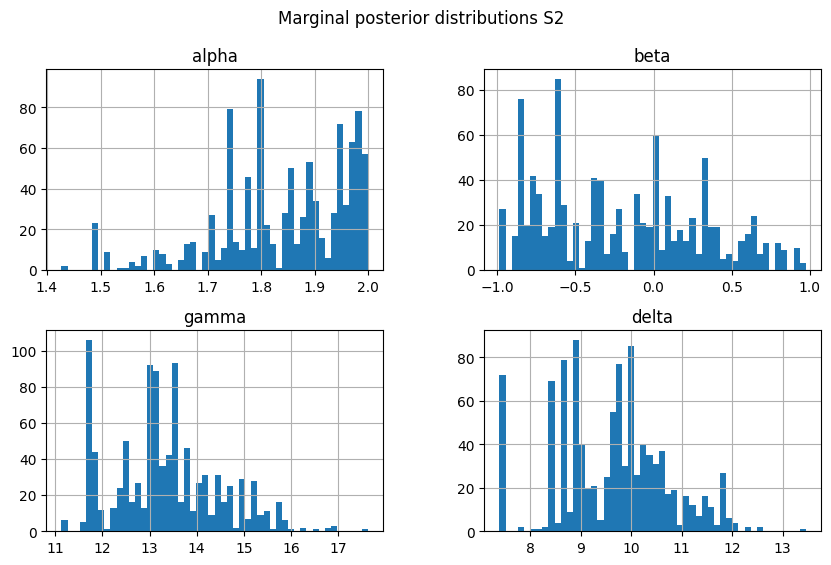

alpha  mean = 1.839,  95% CI = [1.510, 1.992]
beta   mean = -0.201,  95% CI = [-0.985, 0.813]
gamma  mean = 13.348,  95% CI = [11.656, 15.731]
delta  mean = 9.610,  95% CI = [7.393, 11.812]


In [ ]:
plot_theta(thetas2,2)
plot_theta(thetas3,3)
plot_theta(thetas4,4)
plot_theta(thetas5,5)

The result obtained for each algorithm are then presented

| Parameter | Mean    | 95 % CI low | 95 % CI high | Statistic |
|-----------|:-------:|:-----------:|:------------:|----:      |
| α (1.7)   | 1.539   | 1.245       | 1.847        | S2        |
| β (0.9)   | -0.588  | −0.976      | 0.234        | S2        |
| γ (10)    | 28.118  | 17.183      | 39.411       | S2        |
| δ (10)    | 11.473  | 3.060       |  20.681      | S2        |


| Parameter | Mean    | 95 % CI low | 95 % CI high | Statistic |
|-----------|:-------:|:-----------:|:------------:|----:      |
| α (1.7)   | 1.556   | 1.125       | 1.972        | S3        |
| β (0.9)   | -0.020  | −0.939      | 0.937        | S3        |
| γ (10)    | 199.174 | 64.653      | 292.269      | S3        |
| δ (10)    | -21.951 | -282.838    |  288.510     | S3        |



| Parameter | Mean    | 95 % CI low | 95 % CI high | Statistic |
|-----------|:-------:|:-----------:|:------------:|----:      |
| α (1.7)   | 1.682   | 1.604       | 1.769        | S4        |
| β (0.9)   | 0.728   | 0.414       | 0.985        | S4        |
| γ (10)    | 149.742 | 13.383      | 292.269      | S4        |                       
| δ (10)    | 2.859   | -280.892    | 288.510      | S4        |






| Parameter | Mean    | 95 % CI low | 95 % CI high | Statistic |
|-----------|:-------:|:-----------:|:------------:|----:      |
| α (1.7)   | 1.590   | 1.139       | 1.977        | S5        |
| β (0.9)   | 0.288   | −0.719      | 0.951        | S5        |
| γ (10)    | 9.890   | 7.472       | 12.230       | S5        |
| δ (10)    | 8.961   | 6.079       |  12.273      | S5        |


In [ ]:
#TETSTTETST # pour Sobol

# ------------------------------------------------------------------
#  1.  Briques élémentaires vectorisées
# ------------------------------------------------------------------

@jax.jit                                # compilée une fois pour toute
def summary_stat_2_jax(X, ksi=0.25):
    """
    X : (..., m) – n'importe quel lot de séries
    Renvoie : (..., 4) – statistiques résumées (v_hat, eta_hat, teta_hat, delta_hat)
    """
    X      = jnp.asarray(X)
    m      = X.shape[-1]                # longueur de la série
    L      = (m // 3) * 3               # multiple de 3 le plus proche
    X_trim = X[..., :L]                 # tronque l'excédent éventuel
    X_3    = X_trim.reshape(*X.shape[:-1], -1, 3)   # (..., n_triplets, 3)

    # Z_i = x_{3i-2} - ksi·x_{3i-1} - (1-ksi)·x_{3i}
    Z = X_3[..., 0] - ksi * X_3[..., 1] - (1 - ksi) * X_3[..., 2]

    V        = jnp.log(jnp.abs(Z))
    U        = jnp.sign(X)

    S_V      = jnp.var(V, axis=-1)              # (...,)
    S_U      = jnp.var(U, axis=-1)
    eta_hat  = jnp.mean(U, axis=-1)
    teta_hat = jnp.mean(V, axis=-1)

    v_tilde  = 6 / (jnp.pi**2) * S_V - 1.5 * S_U + 1.0
    v_hat    = jnp.maximum(v_tilde, 0.25 * (1 + eta_hat)**2)

    delta_hat = jnp.mean(X, axis=-1)

    return jnp.stack([v_hat, eta_hat, teta_hat, delta_hat], axis=-1)

summary_statistics_vec = jax.vmap(summary_stat_2_jax, in_axes=0)



def distance_function(S_sim, S_obs):
    """
    Renvoie ‖S_sim - S_obs‖² pour un lot (… , k).
    Aucun sqrt --> plus rapide et évite les underflow dans le noyau.
    """
    diff = S_sim - S_obs
    return jnp.einsum('...i,...i->...', diff, diff)     # (…)

def prior_pdf(theta):
    """
    Theta : (...,4)  ➜ densité uniforme sur le pavé.
    Renvoie un tableau shape (...) de floats.
    """
    alpha, beta, gamma, delta = theta[...,0], theta[...,1], theta[...,2], theta[...,3]
    mask = (
        (alpha >= 1.1) & (alpha <= 2.0) &
        (beta  >= -1.) & (beta  <= 1.)  &
        (gamma >= 0.)  & (gamma <= 300.)&
        (delta >= -300)& (delta <= 300.)
    )
    base = 1.0 / ((2-1.1) * 2 * 300 * 600)
    return jnp.where(mask, base, 0.0)

# --- noyau de perturbation (Gaussien) ------------------------------
def perturb(key, theta, cov):
    """
    Tirage unique OU vectorisé :
        theta : (...,4)
        cov   : (4,4)
    """
    L = jnp.linalg.cholesky(cov)
    eps = random.normal(key, shape=theta.shape)
    return theta + eps @ L.T

def kernel_pdf(theta_new, thetas, cov, weights):
    """
    Densité du noyau mutation M_t évaluée en theta_new (…,4).
    Implémentation vectorisée d'un mélange Gaussien.
    """
    theta_new = jnp.atleast_2d(theta_new)              # (M,4)
    diff      = theta_new[:,None,:] - thetas[None,:,:] # (M,N,4)
    inv_cov   = jnp.linalg.inv(cov)
    maha      = jnp.einsum('...i,ij,...j->...', diff, inv_cov, diff)  # (M,N)
    k         = thetas.shape[1]
    norm_cste = 1.0 / jnp.sqrt((2*jnp.pi)**k * jnp.linalg.det(cov))
    mvn       = norm_cste * jnp.exp(-0.5 * maha)       # (M,N)
    return (mvn * weights).sum(axis=1)                 # (M,)

# --- noyau gaussien ABC sans racine -------------------------------
def kernel_gaussian(dist2, eps):
    return jnp.exp(- dist2 / (2 * eps * eps))

# ------------------------------------------------------------------
#  2.  Simulateur alpha-stable vectorisé (JAX + Sobol pré-calculé)
# ------------------------------------------------------------------

def sobol_2d(n_max, *, scramble=True, seed=None, dtype=jnp.float32):
    sampler = qmc.Sobol(2, scramble=scramble, seed=seed)
    return jnp.asarray(sampler.random(n_max), dtype=dtype)

@partial(jax.jit, static_argnames=("m",))
def simulate_alpha_stable_batch(theta, sobol_pts, *, m):
    """theta : (P,4) ➜ (P,m)"""
    alpha, beta, gamma, delta = jnp.split(theta, 4, axis=1)
    u = sobol_pts[:m,0] * jnp.pi - jnp.pi/2
    v = sobol_pts[:m,1]
    w = -jnp.log(v + 1e-10)

    u = u[None,:] ; w = w[None,:]            # broadcast (1,m)
    half_pi = jnp.pi / 2

    def cms_eq1(a,b):
        return (2/jnp.pi)*((half_pi+b*u)*jnp.tan(u) -
                           b*jnp.log((half_pi*w*jnp.cos(u))/(half_pi+b*u)))

    def cms_neq1(a,b):
        S = (1 + b**2*jnp.tan(half_pi*a)**2)**(1/(2*a))
        B = (1/a)*jnp.arctan(b*jnp.tan(half_pi*a))
        return S*(jnp.sin(a*(u+B))/jnp.cos(u)**(1/a))*(
                 (jnp.cos(u - a*(u+B)))/w)**((1-a)/a)

    y = jnp.where(jnp.abs(alpha-1)<1e-6, cms_eq1(alpha,beta), cms_neq1(alpha,beta))
    return gamma*y + delta                   # (P,m)

def simulate_data_vec(theta, n_sim, *, sobol_cache=None):
    """wrapper pratique"""
    if sobol_cache is None or sobol_cache.shape[0] < n_sim:
        sobol_cache = sobol_2d(n_sim)
    return simulate_alpha_stable_batch(theta, sobol_cache, m=n_sim)

# ------------------------------------------------------------------
#  3.  SMC-PRC-ABC vectorisé en log-poids
# ------------------------------------------------------------------

def multinomial_resample(key, particles, weights):
    N  = len(particles)
    idx= random.choice(key, N, shape=(N,), p=weights)
    return particles[idx], jnp.full(N, 1.0/N)

def prc_abc_gaussian_kernel_vec(
    key,                                     # PRNGKey JAX
    x_obs, summary_statistics,
    *, N=1_000, T=6, epsilons=None,
    oversample=1.5, batch_size=256
):
    if epsilons is None:
        epsilons = jnp.linspace(2.0, 0.2, T)

    m     = len(x_obs)
    S_obs = summary_statistics(x_obs)
    d     = prior_sample(1).shape[1]         # <-- bug corrigé

    sobol_cache = sobol_2d(m)                # une seule fois

    # ---------- génération 0 ----------
    N_init   = int(N*oversample)
    theta0   = prior_sample(N_init)          # (N_init,4)
    S_sim0   = summary_statistics(simulate_data_vec(theta0, m, sobol_cache=sobol_cache))
    dist20   = distance_function(S_sim0, S_obs)
    idx0     = jnp.argsort(dist20)[:N]
    thetas   = theta0[idx0]
    dist2    = dist20[idx0]

    w        = kernel_gaussian(dist2, epsilons[0])
    w       /= w.sum()

    key, sub = random.split(key)
    thetas, w = multinomial_resample(sub, thetas, w)   # poids = 1/N

    particles = [thetas]
    weights   = [w]

    # ---------- itérations t = 1 … T-1 ----------
    for t in range(1, T):
        Σ = 2*(jnp.cov(thetas.T, aweights=w)+1e-6*jnp.eye(d))
        key, sub = random.split(key)
        L = jnp.linalg.cholesky(Σ)

        new_θ  = []
        logW   = []

        while len(new_θ) < N:
            # ----------- tirage par lots -----------
            key, sub1, sub2 = random.split(key,3)
            idx_batch = random.choice(sub1, N, (batch_size,), p=w)
            θ_prop    = thetas[idx_batch] + random.normal(sub2,(batch_size,d)) @ L.T

            prior_vals = prior_pdf(θ_prop)
            mask       = prior_vals > 0
            if not mask.any():
                continue
            θ_prop     = θ_prop[mask]
            prior_vals = prior_vals[mask]

            # -------- simulate + distance ----------
            S_sim      = summary_statistics(simulate_data_vec(θ_prop, m, sobol_cache=sobol_cache))
            dist2_prop = distance_function(S_sim, S_obs)
            K_t        = kernel_gaussian(dist2_prop, epsilons[t])

            # -------- importance weights (log) -----
            log_prior  = jnp.log(prior_vals)
            kern_mix   = kernel_pdf(θ_prop, thetas, Σ, w)
            log_kernel = jnp.where(kern_mix>0, jnp.log(kern_mix), -jnp.inf)
            logW_batch = log_prior + jnp.log(K_t) - log_kernel

            new_θ.append(θ_prop)
            logW.append(logW_batch)

        new_θ  = jnp.concatenate(new_θ)[:N]
        logW   = jnp.concatenate(logW)[:N]
        logW  -= logsumexp(logW)            # normalise
        w      = jnp.exp(logW)

        # ---------- PRC (90e centile) -------------
        c_t    = jnp.percentile(w,90)
        keep   = random.uniform(key, (N,)) < (w / c_t)
        thetas = new_θ[keep][:N]
        w      = w[keep][:N] / w[keep][:N].sum()

        # ---------- resampling --------------------
        key, sub = random.split(key)
        thetas, _ = multinomial_resample(sub, thetas, w)
        w = jnp.full(N, 1.0/N)

        particles.append(thetas)
        weights.append(w)

    return particles[-1], weights[-1]
